### Single Run with Priority

This notebook is developed based on single run for multiple containers. One dredging vessel along with one seagoing vessel serve the same berth area.
The aim of this notebook is to find out how the single run and vessels log change when
* case 1: the dredging vessel is prior
* case 2: the seagoing vessel is prior

In [11]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime, time
import simpy
import openclsim
import opentnsim

import pandas as pd

import matplotlib.pyplot as plt
import folium

ImportError: cannot import name 'Location' from 'openclsim.core.priority' (C:\Users\asepehri\github\OpenCLSim\src\openclsim\core\priority.py)

In [ ]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

Number of edges is 4


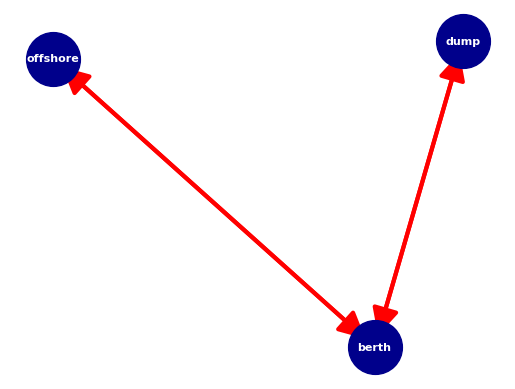

In [ ]:
# we start with creating a graph 
graph = nx.DiGraph()

# make your preferred Site class out of available mix-ins which is a combination of mixins from OpenCLSim and OpenTNSim.
Location = type('Site',
            (openclsim.core.Identifiable,
             openclsim.core.Log,
             openclsim.core.Locatable,
             openclsim.core.HasContainer,
             openclsim.core.HasResource,), {})

# three locations (offshore, berth, and dump) are defined to allow the vessels pass the nodes back and forth.
# based on the mixins, more attributes are defined for each location.
locations = []

location_offshore = shapely.geometry.Point(3.637610458072877, 52.10701582514347)
data_offshore = {"env": my_env,
                 "name": "offshore",
                 "geometry": location_offshore,
                 "capacity": 100,
                 "level": 100,
                }
locations.append(Location(**data_offshore))
offshore = Location(**data_offshore)

location_berth = shapely.geometry.Point(4.062705498083785,51.95909715255291)
data_berth = {"env": my_env,
              "name": "berth",
              "geometry": location_berth,
              "capacity": 100,
              "level": 100,
             }
locations.append(Location(**data_berth))
berth = Location(**data_berth)

location_dump = shapely.geometry.Point(4.1795229742823,52.11590591837503)
data_dump = {"env": my_env,
             "name": "dump",
             "geometry": location_dump,
             "capacity": 100,
             "level": 0
            }
locations.append(Location(**data_dump))
dump = Location(**data_dump)   
        
# a graph is initiated based on the name and gemometry of locations.
# other attributes such as store_capacity and initials are not being used for drawing the graph.
for location in locations:
    graph.add_node(location.name,
                geometry = location.geometry)
     
# add edges
path = [[locations[i], locations[i+1]] for i in range(len(locations)-1)]

for index, edge in enumerate(path):
    graph.add_edge(edge[0].name, edge[1].name, weight = 1)
    
# toggle to undirected and back to directed to make sure all edges are two way traffic
graph = graph.to_undirected() 
graph = graph.to_directed()

# create a positions dict for the purpose of plotting
positions = {}
for location in graph.nodes:
    positions[location] = (graph.nodes[location]['geometry'].x, graph.nodes[location]['geometry'].y)
    
# collect node labels.
labels = {}
for location in graph.nodes:
    labels[location] = location
print('Number of edges is {}'.format(len(graph.edges)))

# draw edges, nodes and labels.
nx.draw_networkx_edges(graph,  pos=positions, width=3, edge_color="red", alpha=1, arrowsize=40)
nx.draw_networkx_nodes(graph,  pos=positions, node_color="darkblue", node_size=1500)
nx.draw_networkx_labels(graph, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="white")

plt.axis("off")
plt.show()

In [ ]:
# add a graph to the environment
my_env.graph = graph

In [ ]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource  object based on desired mixin classes
Vessel_obj_01 = type(
    "TransportProcessingResource",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.ContainerDependentMovable,
        openclsim.core.Processor,
        openclsim.core.HasResource,
        openclsim.core.LoadingFunction,
        openclsim.core.UnloadingFunction,
        openclsim.core.Priority,
    ),
    {},
)

In [ ]:
# data from_site
data_from_site = {
    "env": my_env,
    "name": berth,
    "geometry": location_berth,
    "capacity": 100,
    "level": 100
}
# instantiate from_site 
from_site = Site(**data_from_site)

# data to_site
data_to_site = {
    "env": my_env,
    "name": dump,
    "geometry": location_dump,
    "capacity": 100,
    "level": 0
}
# instantiate to_site 
to_site = Site(**data_to_site)

In [5]:
# prepare input data for vessel_01
data_vessel01 = {
    "env": my_env,
    "name": "vessel01",
    "geometry": location_berth, 
    "loading_rate": 1,
    "unloading_rate": 5,
    "capacity": 10,
    "type":"dredging_vessel",
    "priority": 1,
    "container": "soil",
    "compute_v": lambda x: 10 + 2 * x,
}
# instantiate vessel_01 
vessel01 = Vessel_obj_01(**data_vessel01)
# assert not vessel01.metadata

NameError: name 'my_env' is not defined

In [ ]:
# initialise registry
registry = {}

In [ ]:
# create a 'while activity' that contains a pre-packed set of 'sub_processes'
single_run, while_activity  = openclsim.model.single_run_process(
    name="single_run",
    registry={},
    env=my_env,
    origin=berth,
    destination=dump,
    mover=vessel01,
    loader=vessel01,
    unloader=vessel01,
)
# activity = openclsim.model.MoveActivity(
#     env=my_env,
#     name="Move activity of dredging vessel",
#     registry=registry,
#     mover=vessel01,
#     destination=dump,
# )

In [ ]:
openclsim.model.register_processes([while_activity])

In [ ]:
my_env.run()

mover vessel01 destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover vessel01 destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover vessel01 destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover vessel01 destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover vessel01 destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover vessel01 destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover vessel01 destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover vessel01 destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover vessel01 destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover vessel01 destina

In [ ]:
display(openclsim.plot.get_log_dataframe(activity))

NameError: name 'activity' is not defined

In [ ]:
# define a path into and out of the habour
path1 = nx.dijkstra_path(my_env.graph, 'offshore', 'berth')
path2 = nx.dijkstra_path(my_env.graph, 'berth', 'offshore')
path = path1+path2[1:]
display(path)
    
# create a dict with all important settings
data_vessel02 = {"env": my_env,                     # needed for simpy simulation
               "name": 'seagoing vessel',           # required by Identifiable
               "geometry": location_offshore        # required by Locatable
               "route": path,                       # required by Routeable
               "priority": 2,                       # the seagoing vessel has the second priority to serve the berth location
               "v": 1,}                             # required by Movable

# instantiate vessel_02 
vessel02 = TransportProcessingResource(**data_vessel02)
assert not vessel02.metadata

In [ ]:
# specify the process that needs to be executed
my_env.process(vessel02.move())

In [ ]:
# start the simulation
my_env.run()

In [ ]:
display(openclsim.plot.get_log_dataframe(vessel01, [*single_run, while_activity]))

In [ ]:
openclsim.plot.get_gantt_chart([while_activity, vessel01, *single_run])

In [ ]:
fig = openclsim.plot.get_step_chart([berth, dump, vessel01])

In [ ]:
vessel02.log

In [ ]:
# note the slightly different log handling than for the openclsim elemnents
df = pd.DataFrame.from_dict(vessel02.log)
df